1. Get data (yfinance/api)
2. find mean, stdev and correlation
3. create table for weightage
4. create MVP portfolio (solver) 
5. plot MVP line with CAL line
6. 

In [1]:
# Import Library
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciop
from datetime import datetime
import os

## Calculation

In [2]:
# Create a matrix of stock return and standard deviation
asset_risk_free = 0.05

asset_risk_return_dict={"Return":{"US":0.1355, "UK":0.1589,"France":0.1519,"Germany":0.1435,"Japan":0.1497},
                        "Deviation":{"US":0.1535, "UK":0.2430,"France":0.2324,"Germany":0.2038,"Japan":0.2298},
                        }

asset_correlation_matrix_dict={"US":{"US":1,"UK":0.5003,"France":0.4398,"Germany":0.3681,"Japan":0.2663},
                          "UK":{"US":0.5003,"UK":1,"France":0.5420,"Germany":0.4265,"Japan":0.3581},
                          "France":{"US":0.4398,"UK":0.5420,"France":1,"Germany":0.6032,"Japan":0.3923},
                          "Germany":{"US":0.3681,"UK":0.4265,"France":0.6032,"Germany":1,"Japan":0.3663},
                          "Japan":{"US":0.2663,"UK":0.3581,"France":0.3923,"Germany":0.3663,"Japan":1}}

asset_risk_return= pd.DataFrame(asset_risk_return_dict)
asset_correlation_matrix= pd.DataFrame(asset_correlation_matrix_dict)

# Create weight range from 0 to 1 (inclusive) with 0.1 intervals
w_us = np.round(np.arange(-1, 1.1, 0.05), 3)
w_japan = np.round(1 - w_us, 3)

# Create DataFrame with weight range
portfolio_weights = pd.DataFrame({
    "w1": w_us,
    "w2": w_japan
})

# Create a range of return based on weightage
portfolio_return_list=[]
for index,row in portfolio_weights.iterrows():
    us_return= row["w1"]*asset_risk_return["Return"]["US"]
    jp_return= row["w2"]*asset_risk_return["Return"]["Japan"]
    weighted_portfolio_return= us_return+jp_return
    portfolio_return_list.append(weighted_portfolio_return)

# Create Dataframe of weighted return
portfolio_mean=pd.DataFrame({
    "return":portfolio_return_list
})

# Calculate Variance for each weight
portfolio_variance_list=[]
for index, row in portfolio_weights.iterrows():
    us_volatility= (row["w1"])**2 *asset_risk_return["Deviation"]["US"] **2
    jp_volatility= (row["w2"])**2 *asset_risk_return["Deviation"]["Japan"] **2
    us_jp_deviation= 2*(row["w1"])*(row["w2"])*asset_risk_return["Deviation"]["US"]*asset_risk_return["Deviation"]["Japan"] *asset_correlation_matrix["US"]["Japan"]
    weighted_risk=us_volatility+jp_volatility+us_jp_deviation
    portfolio_variance_list.append(weighted_risk)

# Calculate Standard Deviation for each weight
portfolio_stdev_list=[]
for var in portfolio_variance_list:
    portfolio_stdev_list.append((np.sqrt(var)))

# Calculate Volatility for each weight
portfolio_volatility=pd.DataFrame({
    "variance":portfolio_variance_list,
    "stdev":portfolio_stdev_list
})

# Calculate Sharpe Ratio for each weight
portfolio_sharpe_list=[]
for idx, mean in enumerate(portfolio_return_list):
    sharpe= (mean-asset_risk_free)/portfolio_stdev_list[idx]
    portfolio_sharpe_list.append(sharpe)

# Merge all data into df
capital_allocation_matrix=pd.DataFrame({
    "w(US)":w_us,
    "w(Japan)":w_japan,
    "Mean Return":portfolio_return_list,
    "Variance":portfolio_variance_list,
    "Standard Deviation": portfolio_stdev_list,
    "Sharpe Ratio": portfolio_sharpe_list
})


In [3]:
# Finding MVP ratio

def variance_function(weight):
    us_volatility= weight**2 *asset_risk_return["Deviation"]["US"] **2
    jp_volatility= (1-weight)**2 *asset_risk_return["Deviation"]["Japan"] **2
    us_jp_deviation= 2*(weight)*(1-weight)*asset_risk_return["Deviation"]["US"]*asset_risk_return["Deviation"]["Japan"] *asset_correlation_matrix["US"]["Japan"]
    weighted_risk=us_volatility+jp_volatility+us_jp_deviation
    return weighted_risk

result=sciop.minimize(variance_function,-1,method="SLSQP")
MVP_weight_US=result["x"][0]
MVP_minimum_variance=result["fun"]

us_return= MVP_weight_US*asset_risk_return["Return"]["US"]
jp_return= (1-MVP_weight_US)*asset_risk_return["Return"]["Japan"]
weighted_portfolio_return= us_return+jp_return

MVP_Portfolio= {
"w(US)": MVP_weight_US,
"w(Japan)": 1-MVP_weight_US,
"Mean Return": weighted_portfolio_return,
"Variance": MVP_minimum_variance,
"Standard Deviation": np.sqrt(MVP_minimum_variance),
"Sharpe Ratio": (weighted_portfolio_return-asset_risk_free)/np.sqrt(MVP_minimum_variance)
}

In [4]:
# Creating Capital Allocation Line

# Finding MVE Point
def neg_sharpe_function(weight_US):
    # Calculate Mean Return
    us_return= weight_US*asset_risk_return["Return"]["US"]
    jp_return= (1-weight_US)*asset_risk_return["Return"]["Japan"]
    weighted_return=us_return+jp_return

    # Calculate Standard Deviation
    us_volatility= weight_US**2 *asset_risk_return["Deviation"]["US"] **2
    jp_volatility= (1-weight_US)**2 *asset_risk_return["Deviation"]["Japan"] **2
    us_jp_deviation= 2*(weight_US)*(1-weight_US)*asset_risk_return["Deviation"]["US"]*asset_risk_return["Deviation"]["Japan"] *asset_correlation_matrix["US"]["Japan"]
    weighted_variance=us_volatility+jp_volatility+us_jp_deviation
    weighted_stdev=np.sqrt(weighted_variance)

    sharpe_ratio= (weighted_return-asset_risk_free)/weighted_stdev
    return - sharpe_ratio

sciop.minimize(neg_sharpe_function,0, method="SLSQP")

result=sciop.minimize(neg_sharpe_function,0, method="SLSQP")
MVE_weight_US=result["x"][0]
MVE_Sharpe=-result["fun"]

# Calculate Return of MVE Portfolio
MVE_us_return= MVE_weight_US*asset_risk_return["Return"]["US"]
MVE_jp_return= (1-MVE_weight_US)*asset_risk_return["Return"]["Japan"]
MVE_weighted_portfolio_return= MVE_us_return + MVE_jp_return

# Calculate Standard Deviation of MVE Portfolio
us_volatility= MVE_weight_US**2 *asset_risk_return["Deviation"]["US"] **2
jp_volatility= (1-MVE_weight_US)**2 *asset_risk_return["Deviation"]["Japan"] **2
us_jp_deviation= 2*(MVE_weight_US)*(1-MVE_weight_US)*asset_risk_return["Deviation"]["US"]*asset_risk_return["Deviation"]["Japan"] *asset_correlation_matrix["US"]["Japan"]
MVE_weighted_variance=us_volatility+jp_volatility+us_jp_deviation
MVE_weighted_stdev=np.sqrt(MVE_weighted_variance)

MVE_Portfolio= {
"w(US)": MVE_weight_US,
"w(Japan)": 1-MVE_weight_US,
"Mean Return": MVE_weighted_portfolio_return,
"Variance": MVE_weighted_variance,
"Standard Deviation": MVE_weighted_stdev,
"Sharpe Ratio": MVE_Sharpe}

In [5]:
# Finding Capital Allocation Line

# Create weight range from 0 to 1 (inclusive) with 0.1 intervals
w_risky = np.round(np.arange(0, 1.1, 0.05), 3)
w_riskfree = np.round(1 - w_risky, 3)

# Create DataFrame with weight range
capital_allocation_weight = pd.DataFrame({
    "w1": w_risky,
    "w2": w_riskfree
})

# Create a range of return based on weightage
capital_allocation_return_list=[]
for index,row in capital_allocation_weight.iterrows():
    risky_return= row["w1"]*MVE_Portfolio["Mean Return"]
    riskfree_return= row["w2"]*asset_risk_free
    weighted_portfolio_return= risky_return+riskfree_return
    capital_allocation_return_list.append(weighted_portfolio_return)

# Calculate Variance for each weight
capital_allocation_variance_list=[]
for index, row in capital_allocation_weight.iterrows():
    total_volatility= (row["w1"])**2 *MVE_Portfolio["Standard Deviation"] **2
    capital_allocation_variance_list.append(total_volatility)

# Calculate Standard Deviation for each weight
capital_allocation_stdev_list=[]
for var in capital_allocation_variance_list:
    capital_allocation_stdev_list.append((np.sqrt(var)))

# Calculate Sharpe Ratio for each weight
capital_allocation_sharpe_list=[]
for idx, weight in capital_allocation_weight.iterrows():
    capital_allocation_sharpe_list.append(MVE_Portfolio["Sharpe Ratio"])

# Merge all data into df
capital_allocation_matrix=pd.DataFrame({
    "w(MVE)":w_risky,
    "w(Risk Free)":w_riskfree,
    "Mean Return":capital_allocation_return_list,
    "Variance":capital_allocation_variance_list,
    "Standard Deviation": capital_allocation_stdev_list,
    "Sharpe Ratio": capital_allocation_sharpe_list
})

## Plotting

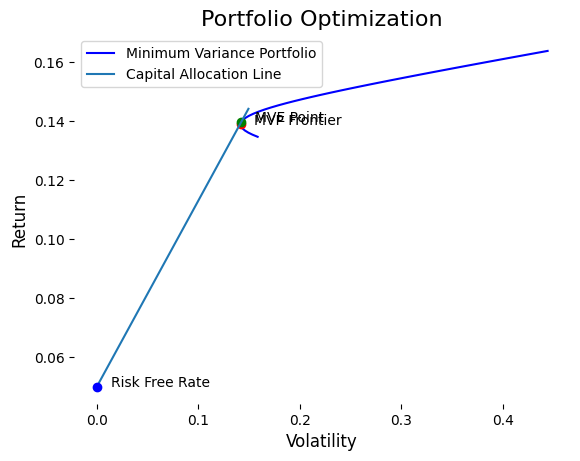

In [6]:
fig,ax= plt.subplots()

# Plotting Curve
ax.plot(portfolio_stdev_list,portfolio_return_list,"b-",label="Minimum Variance Portfolio")

# Plotting MVP Point
ax.plot(MVP_Portfolio["Standard Deviation"],MVP_Portfolio["Mean Return"],"ro")
plt.annotate(text=f"MVP Frontier",
             xy=(MVP_Portfolio["Standard Deviation"],MVP_Portfolio["Mean Return"]),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")

#Plotting MVE Point
ax.plot(MVE_Portfolio["Standard Deviation"],MVE_Portfolio["Mean Return"],"go")
plt.annotate(text=f"MVE Point",
             xy=(MVE_Portfolio["Standard Deviation"],MVE_Portfolio["Mean Return"]),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")

#Plotting CAL Line
ax.plot(capital_allocation_stdev_list,capital_allocation_return_list,label="Capital Allocation Line")

# Annotating the Risk Free Rate
ax.plot(0,asset_risk_free,"bo")
plt.annotate(text=f"Risk Free Rate",
             xy=(0,asset_risk_free),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")

# Formatting the Graph Title, Axis and Borders
plt.title("Portfolio Optimization",fontsize=16)
plt.legend()
plt.xlabel("Volatility",fontsize=12)
plt.ylabel("Return",fontsize=12)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

In [ ]:
ticker=["US","UK","Japan"]

# run through yfinance

# calculate mean and stdev for each ticker

# calculate correlation between the ticker

# generate the dataframe